---
title: "Using The Excel Object Model in Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
description: "Programmatically interact with Excel using `xlwings` and `pywin32` to produce formatted tables."
date: "2025-3-12"
image: thumbnail.png
draft: false
categories: ['Python', 'Data Management']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [21]:
import pandas as pd
import numpy as np
import xlwings as xw
import os

In this post, I'm going to overview how to use Python's `xlwings` and `pywin32` libraries to produce formatted, human-readable tables in Excel. Beyond basic uses of `xlwings`, I'll overview how to leverage `pywin32` and the `.api` attribute to interact directly with the Excel object model using VBA-like Python code. The approach allows one to produce highly customizable Excel tables that should satisfy any audience that prefers formatted spreadsheet output rather than, say, a quarto doc.

Alongside this blog post, I've been developing an `excel` submodule in my `swiss-code` package, with various wrapper functions for `xlwings` and `pywin32`. I'll also use this post to showcase that submodule, and specifically the `ExcelDataFrame` class that I've developed to integrate a given `pandas` dataframe with a corresponding table range in Excel.

## Problem Setup

In [22]:
#| code-fold: true
#| code-summary: "Code for dataset generation"
def simulate_df(num_transactions=1000):
    np.random.seed(1)
    customer_ids = np.random.randint(1000, 5000, num_transactions)
    transaction_amounts = np.round(np.random.uniform(5, 500, num_transactions), 2)
    payment_methods = np.random.choice(["Credit Card", "Debit Card", "PayPal", "Cash"], num_transactions)
    categories = np.random.choice(["Electronics", "Clothing", "Groceries", "Entertainment"], num_transactions)
    transaction_dates = pd.date_range(start="2024-01-01", periods=num_transactions, freq="D")
    data = {
        "transaction_id": range(1, num_transactions + 1),
        "customer_id": customer_ids,
        "amount": transaction_amounts,
        "payment_method": payment_methods,
        "category": categories,
        "date": transaction_dates
    }
    df = pd.DataFrame(data)
    df['year'] = df['date'].dt.year.astype(str)
    df["class"] = df["category"].map(
        {
            "Clothing": "Necessity",
            "Groceries": "Necessity",
            "Electronics": "Discretionary",
            "Entertainment": "Discretionary",
        }
    )
    return df

Say we have a dataset of customer transactions at a super store. I simulated this data arbitrarily.

In [23]:
df = simulate_df()
df.head()

,transaction_id,customer_id,amount,payment_method,category,date,year,class
0,1,2061,177.75,Debit Card,Electronics,2024-01-01,2024,Discretionary
1,2,1235,33.20,Credit Card,Clothing,2024-01-02,2024,Necessity
2,3,4980,118.26,Credit Card,Groceries,2024-01-03,2024,Necessity
3,4,2096,333.73,Debit Card,Entertainment,2024-01-04,2024,Discretionary
4,5,4839,251.14,Credit Card,Electronics,2024-01-05,2024,Discretionary


Let's imagine the case where a stakeholder asks for a report on the following:  

- Total dollars transacted, broken down by key categories and payment method.

It's fairly straightforward to use `pandas` to make a pivot table report, complete with human-readable, title-cased indices and columns. In this case, I've aggregated the total dollars spent, dissagregated by payment method and category of good. Some users prefer that the pivot table also include subtotals, and we flexibly add those with `margins=True`.

In [24]:
dollars_by_method = df.pivot_table(
    index="payment_method",
    columns="category",
    values="amount",
    aggfunc="sum",
    margins=True,
    margins_name="Total",
)
dollars_by_method.index.name = "Payment Method"
dollars_by_method.columns.name = "Category"
dollars_by_method

Category,Clothing,Electronics,Entertainment,Groceries,Total
Payment Method,,,,,
Cash,15016.00,17026.47,18208.16,18242.88,68493.51
Credit Card,16074.92,10960.64,16052.85,20187.25,63275.66
Debit Card,14032.23,17325.96,14363.99,17188.67,62910.85
PayPal,14143.84,15108.84,16852.17,12065.14,58169.99
Total,59266.99,60421.91,65477.17,67683.94,252850.01


That's a fine-enough `pandas` dataframe, but now the question arises of how to best serve this data to the end-user.  

There are several options -- lately I've been using Quarto reports or else Tableau dashboards for these sorts of analytics projects. However, those formats are very "finalized" and can be a little unsatisfying for end-users who want to further filter or modify table output. If that audience doesn't use R/Python, access to underlying `.ipynb` or `.qmd` files will not be helpful. This is the case where I think that spreadsheet output, and specifically reproducible, formatted Excel worksheets, can be very potent.

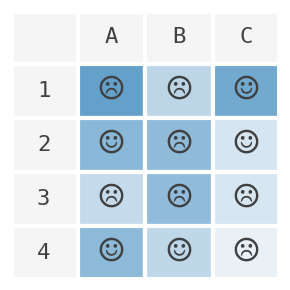

In [25]:
#| echo: false
#| output: false
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(2)
rows, cols = 4, 3
data = np.random.randint(100, 999, size=(rows, cols))
fig, ax = plt.subplots(figsize=(3, 3))

for i in range(rows + 1):
    for j in range(cols + 1):
        # Header row (letters)
        if i == 0:
            text = chr(65 + j - 1) if j > 0 else ""  # A, B, C, etc.
            color = "#404040"
            bgcolor = (.816, .816, .816, .2)
            fontsize=16
        # Index column (numbers)
        elif j == 0:
            text = str(i)
            color = "#404040"
            bgcolor = (.816, .816, .816, .2)
            fontsize=16
        else:
            text = np.random.choice(["☺", "☹"])
            color = "#404040"
            bgcolor = (.122, .467, .706, np.random.uniform()) # Alternating row colors
            fontsize=30
        ax.add_patch(
            plt.Rectangle((j, rows - i), 1, 1, fc=bgcolor, ec="white", lw=3)
            )
        ax.text(j + 0.5, rows - i + 0.5, text, ha="center", va="center", 
                fontsize=fontsize, fontfamily="monospace", color=color)
        
ax.add_patch(plt.Rectangle((0, 0), cols + 1, rows + 1, fill=False, edgecolor="white", lw=5))
ax.set_xlim(0, cols + 1)
ax.set_ylim(0, rows + 1)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout()
fig.savefig('thumbnail.png', dpi=300)

## Getting connected to Excel

To write a `pandas` dataframe out to Excel, we'll work through the Excel/`xlwings` [object hierarchy](https://docs.xlwings.org/en/stable/syntax_overview.html#object-hierarchy):  

- Application^[Dealing with the Application object in `xlwings` is optional, and the workflow outlined in this blog just ignores it.] $\rightarrow$ Work Book $\rightarrow$ Sheet $\rightarrow$ Range.  


In `xlwings` we'll establish a `xw.Book` object, which either creates or opens an existing excel work book, in this case `test.xlsx`.

In [26]:
filename = "test.xlsx"
if os.path.exists(filename):
        wb = xw.Book(filename)
else:
    wb = xw.Book()
    wb.save(filename)
wb

<Book [test.xlsx]>

Next, we establish an `xw.Sheet` within that `xw.Book` object, in this case I'll call the sheet `first_test`.

In [27]:
sheet_name = 'first_test'
try:
    sheet_new = wb.sheets.add(sheet_name) 
except ValueError:
    sheet_new = wb.sheets[sheet_name]
sheet_new

<Sheet [test.xlsx]first_test>

At this point, we can select the sheet, `sheet_new`, select a start range, "A1", then set it's value with our dataframe object from the previous section, `dollars_by_method`. This will export the full dataframe into the spreadsheet.

In [28]:
sheet_new.range("A1").options(index=True, header=True).value = dollars_by_method

Then, when we save the book, we can inspect the output by opening `text.xlsx`. Note that the data were entered into cell `A1` and expanded as needed.

In [29]:
wb.save()

![](1.png)

This is an unattractive table, with no formatting and with poorly fitted columns. This is also equivalent to what we could get if we simply used the `df.to_excel()` method within `pandas`. We'll proceed to format this table, that that is where we get the real value out of `xlwings`.

## Interacting with the Excel Object Model

The most powerful aspect of `xlwings` is that it allows for interacting with the Excel object model -- an API for programmatically editing Excel spreadsheets. One would typically interact with Excel's object model via VBA code, but `xlwings` and `pywin32` together allow for us to use Python for a conceptually similar workflow.  

Note that Microsoft provides a few key pieces of documentation that augment [`xlwings`' own API reference](https://docs.xlwings.org/en/stable/api/index.html).

1. An overview of the object model concept and typical VBA workflows in [in the "VBA Programming 101"](https://learn.microsoft.com/en-us/office/vba/library-reference/concepts/getting-started-with-vba-in-office#vba-programming-101) section of the Official VBA Reference, and,
2. A complete reference for the [Excel object model](https://learn.microsoft.com/en-us/office/vba/api/overview/excel/object-model) in the Official VBA Reference.


![Excel Object Model for VBA Reference](object_model.png){width=80%}

We can access the object model API from an `xw.Sheet` object by calling the `.api` attribute:

In [30]:
sheet_new.api

<win32com.gen_py.Microsoft Excel 16.0 Object Library._Worksheet instance at 0x2714414253696>

This is an instance of VBA's Worksheet object, which has [a documentation page in the VBA reference](https://learn.microsoft.com/en-us/office/vba/api/excel.worksheet).  

![The Worksheet Object](worksheet.png){width=80%}

### AutoFit

Python objects have attributes and methods, whereas the VBA Worksheet object has properties and methods. One particularly useful property is `UsedRange`, which stores the range of cells that have data. We often access that property when we want to format a table.

In [31]:
sheet_new.api.UsedRange

<win32com.gen_py.Microsoft Excel 16.0 Object Library.Range instance at 0x2712378707792>

For very popular properties and methods from the Excel object model, such as `UsedRange`, the `xlwings` api has simplified python attributes and methods that allow one to avoid explicity accessing the object model api. E.g. we can call `xw.Sheet.used_range` for similar functionality to `xw.Sheet.UsedRange`.

In [32]:
sheet_new.used_range

<Range [test.xlsx]first_test!$A$1:$F$6>

I'll stick with the former approach for now.

From the `UsedRange` attribute, which is a `Range` object, we can access the [EntireColumn](https://learn.microsoft.com/en-us/office/vba/api/excel.range.entirecolumn) property, which selects the entire columns for a given range.

In [33]:
sheet_new.api.UsedRange.EntireColumn

<win32com.gen_py.Microsoft Excel 16.0 Object Library.Range instance at 0x2712379336816>

This is equivalent to the following selection:

![](1.5.png)

For that `Range` object, we will now call the [Autofit() method](https://learn.microsoft.com/en-us/office/vba/api/excel.range.autofit).

In [34]:
sheet_new.api.UsedRange.EntireColumn.AutoFit()

True

We get the following in Excel:

![](2.png)

Let's autofit the rows and the columns where there is currently data.

In [35]:
sheet_new.api.UsedRange.EntireColumn.AutoFit()
sheet_new.api.UsedRange.EntireRow.AutoFit()
wb.save()

### Number Formatting

Now we'll move onto formatting the data, which represent dollar totals, as follows:  

- `11020` $\rightarrow$ `$11,020`

I'll be using a mix of `xlwings` wrapper methods/attributes, and explicit calls to the Excel object model via `.api`, with no real commitment as to when to use which. Given that we get equivalent results, I'm of the mind that it doesn't particularly matter.  

We can apply dollar formatting to any range in Excel via the [NumberFormat](https://learn.microsoft.com/en-us/office/vba/api/excel.range.numberformat) property -- [`number_format`](https://docs.xlwings.org/en/stable/api/range.html#xlwings.Range.number_format) in `xlwings`. But to do that, we'll first need to define a range that captures exactly where there is numerical data.  

I'll first select the top row of the sheet and retrieve its values, which are the column headers:

In [36]:
headers = sheet_new.range("A1").expand("right").value
headers

['Payment Method',
 'Clothing',
 'Electronics',
 'Entertainment',
 'Groceries',
 'Total']

We now want to access those columns that actually contain data (Payment Method is the index title and doesn't contain data). We'll do this by taking the index of Clothing, the first column with data, adding one,^[Excel indexes from 1 whereas python indexes from 0, so adding 1 will be common in a lot of these workflows]

In [37]:
col_index = headers.index('Clothing') + 1
col_index

2

then retrieving the letter that corresponds to that index:

In [38]:
col_letter = xw.utils.col_name(col_index) 
col_letter

'B'

Given the column letter, we can now select all of the data in that column:

In [39]:
selection = f"{col_letter}2:{col_letter}1000000"
selection

'B2:B1000000'

Then we can set the number format (see [supported Number format codes](https://support.microsoft.com/en-us/office/number-format-codes-in-excel-for-mac-5026bbd6-04bc-48cd-bf33-80f18b4eae68)):

In [40]:
sheet_new.range(selection).number_format = "$#,###.##"
wb.save()

![](3.png)

To format all of the data, we'll just iterate through the columns and execute that same chunk of code:

In [41]:
for col in dollars_by_method.columns:
    col_index = headers.index(col) + 1
    col_letter = xw.utils.col_name(col_index)
    selection = f"{col_letter}2:{col_letter}1048576"
    sheet_new.range(selection).number_format = "$#,###.##"
wb.save()

![](4.png)

### Text Formatting

Now I'd like to bold-format the index to differentiate it from the data.

We'll use a similar process to make the column and index headers bold. I'll translate the dataframe's headers into an Excel range as follows -- I retrieve the numerical index of the last column (indexed from 1)

In [42]:
last_column_index = dollars_by_method.reset_index().shape[1]
last_column_index

6

I translate that into its column letter:

In [43]:
end_col = xw.utils.col_name(last_column_index)
end_col

'F'

Then I use that to define the range of the columns, which are all in row 1:

In [44]:
selection = f"A1:{end_col}1"
selection

'A1:F1'

With that range selection, we can access the [`.font` attribute in `xlwings`](https://docs.xlwings.org/en/stable/api/font.html), which corresponds to the [Font object](https://learn.microsoft.com/en-us/office/vba/api/excel.font(object)) in the Excel object model, and set `bold = True`.

In [45]:
header_range = sheet_new.range(selection)
header_range.font.bold = True
wb.save()

![](5.png)

I'll do the same with the index, capturing its range then setting `bold = True`

In [46]:
end_row = dollars_by_method.reset_index().shape[0] + 1
selection = f"A1:A{end_row}"
selection

'A1:A6'

In [47]:
header_range = sheet_new.range(selection)
header_range.font.bold = True
wb.save()

![](6.png)

### Shading and Borders

To finish the formatting, I'd also like to shade in the grand total column/row so as to differentiate it from unaggregated data, and add basic black borders on all cells.  

We'll be doing much the same as before when it comes to shading in rows/columns -- we define a range that captures an entire target row/column, then access the appropriate object to format that range. I'll reuse the `end_col` and `end_row` values defined above to get the range of the last column

In [48]:
total_col = f"{end_col}1:{end_col}{end_row}"
total_col

'F1:F6'

In excel, we set colors using RGB codes, which I like to get from [https://htmlcolorcodes.com/](https://htmlcolorcodes.com/), though any color-swatch site should suffice.

In [49]:
total_col = f"{end_col}1:{end_col}{end_row}"
sheet_new.range(total_col).color = (242, 242, 242)
total_row = f"A{end_row}:{end_col}{end_row}"
sheet_new.range(total_row).color = (242, 242, 242)
print("Total Column:", total_col, "\nTotal Row:", total_row)
wb.save()

Total Column: F1:F6 
Total Row: A6:F6


![](7.png)

For defining borders, we'll just access the [Borders object](https://learn.microsoft.com/en-us/office/vba/api/excel.borders) from the UsedRange, so that we apply the borders only where there is currently data. We set two properties for the Border:  

- [LineStyle](https://learn.microsoft.com/en-us/office/vba/api/excel.xllinestyle), e.g. solid versus dashed.
- [Weight](https://learn.microsoft.com/en-us/office/vba/api/excel.xlborderweight), e.g. hairline versus thick.
- There are several other properties we can change as needed in the [Border object's properties](https://learn.microsoft.com/en-us/office/vba/api/excel.borders#properties), but I typically just focus on style and weight.^[I found out about these pages through this [excellent stackoverflow answer](https://stackoverflow.com/questions/73014614/win32com-linestyle-excel/73015199#73015199)]

In [50]:
sheet_new.used_range.api.Borders.LineStyle = 1
sheet_new.used_range.api.Borders.Weight = 2
wb.save()

![](8.png)

## A Package approach

`xlwings` is great, but sometimes bridging the gap between working on a `pandas` dataframe and an Excel object can be a little involved. For example, formatting a column requires finding that column within Excel then programatically defining its range, being mindful of the different numerical indexing systems in Python vs. Excel, potential issues with `pd.MultiIndex` objects, etc.  

This can require a lot of code, so I defined a set of wrapper functions, and eventually an entire class, `ExcelDataFrame`, to facilitate moving between `pandas` and Excel. This class is part of the submodule, `swiss_code.excel`, which is a part of my [larger `swiss_code` package](https://github.com/peter-amerkhanian/swiss-code).  

You can download as follows:

```
pip install git+https://github.com/peter-amerkhanian/swiss-code.git@main
```

In [51]:
#| code-fold: true
#| code-summary: "My environment specific setup"
#| output: false
import sys
sys.path.append('../../../swiss-code/src')
%load_ext autoreload
%autoreload 2

Once you have the package installed, you can import the `excel` submodule.

In [52]:
from swiss_code.excel import excel

Given a `pandas` dataframe and an Excel sheet, we can establish an `ExcelDataFrame` object via the `excel.write_df_to_excel` function. This will write the `pandas` dataframe into the Excel sheet, and establish an object that can be further manipulated.

In [53]:
wb = excel.get_or_create_workbook("test.xlsx")
function_sheet = excel.select_sheet('function_sheet', wb)
edf = excel.write_df_to_excel(df=dollars_by_method,
                              sheet=function_sheet,
                              cell_start="A1")
edf

ACTIVE ExcelDataFrame(sheet=function_sheet, range=$A$1:$F$6, df_shape=(5, 5))

We'll now complete all the same formatting tasks as before via method calls:

In [54]:
for col in edf.df.columns:
    edf.format_column_data(col, format="$#,###.##")
edf.make_borders()
edf.format_indices(bold=True, color=None)
edf.format_row('Total', bold="ignore", color="light_grey")
edf.format_column('Total', bold="ignore", color="light_grey")
excel.close_out_book(wb)

Once `excel.close_out_book(wb)` has been called, the `edf` no longer has an active connection to any workbook. 

In [55]:
edf

 DISCONNECTED ExcelDataFrame(sheet=NA, range=NA, df_shape=(5, 5))

## Complex Tables

I'll show some further functionality of the `ExcelDataFrame` class in the case of a much more complicated pivot table. Let's say that a stakeholder wants something like the previous report, but with more disaggregation:  

- Total dollars transacted, broken down by discretionary vs. essential, and broken down by key categories and payment method, for each year available. Include subtotals for each year.  

This is a fairly complex pivot table, and requires a little bit for code beyond just `pd.pivot_table`. I'll iterate over years and generate pivot tables with subtotals for each, then I'll concatenate them together:

In [56]:
# Year Pivots w/ subtotals
dollars_by_method_yr = pd.concat(
    [df[df['year'] == year]
     .pivot_table(index=["payment_method"], 
                  columns=["class", "category"],
                  values="amount",
                  aggfunc="sum",
                  margins=True,
                  margins_name="Total")
                  .reset_index()
                  .assign(Year=year)
                  .set_index(['Year', 'payment_method'])
                  for year in ['2024', '2025', '2026']],
                  axis=0)
dollars_by_method_yr = dollars_by_method_yr.fillna(0)
dollars_by_method_yr

class               Discretionary               Necessity               Total
category              Electronics Entertainment  Clothing Groceries          
Year payment_method                                                          
2024 Cash                 5182.41       8661.28   5709.71   6552.53  26105.93
     Credit Card          2976.99       5334.29   5846.53   7983.28  22141.09
     Debit Card           6997.97       4998.41   4887.89   5603.41  22487.68
     PayPal               5649.27       7034.34   5225.22   3945.90  21854.73
     Total               20806.64      26028.32  21669.35  24085.12  92589.43
2025 Cash                 6148.02       5110.80   4651.67   7717.81  23628.30
     Credit Card          4618.44       5946.31   6843.13   5828.80  23236.68
     Debit Card           6606.99       7087.51   5801.20   4554.53  24050.23
     PayPal               5220.53       5592.94   6203.22   3442.25  20458.94
     Total               22593.98      23737.56  23499.22  21543.39  91374.15
2026 Cash                 5696.04       4436.08   4654.62   3972.54  18759.28
     Credit Card          3365.21       4772.25   3385.26   6375.17  17897.89
     Debit Card           3721.00       2278.07   3343.14   7030.73  16372.94
     PayPal               4239.04       4224.89   2715.40   4676.99  15856.32
     Total               17021.29      15711.29  14098.42  22055.43  68886.43

Then I'll attach a grand total at the bottom:

In [57]:
# Grand Total
dollars_by_method_yr.loc[("Grand Total", ""), :] = (
    df.pivot_table(
        index=["class", "category"],
        values="amount",
        aggfunc="sum",
        margins=True,
        margins_name="Total"
        )["amount"]
        )
# Table Formatting
dollars_by_method_yr.index.names = ["Year", "Payment Method"]
dollars_by_method_yr.columns.names = ['Class', 'Category']
dollars_by_method_yr

Class                      Discretionary               Necessity            \
Category                     Electronics Entertainment  Clothing Groceries   
Year        Payment Method                                                   
2024        Cash                 5182.41       8661.28   5709.71   6552.53   
            Credit Card          2976.99       5334.29   5846.53   7983.28   
            Debit Card           6997.97       4998.41   4887.89   5603.41   
            PayPal               5649.27       7034.34   5225.22   3945.90   
            Total               20806.64      26028.32  21669.35  24085.12   
2025        Cash                 6148.02       5110.80   4651.67   7717.81   
            Credit Card          4618.44       5946.31   6843.13   5828.80   
            Debit Card           6606.99       7087.51   5801.20   4554.53   
            PayPal               5220.53       5592.94   6203.22   3442.25   
            Total               22593.98      23737.56  23499.22  21543.39   
2026        Cash                 5696.04       4436.08   4654.62   3972.54   
            Credit Card          3365.21       4772.25   3385.26   6375.17   
            Debit Card           3721.00       2278.07   3343.14   7030.73   
            PayPal               4239.04       4224.89   2715.40   4676.99   
            Total               17021.29      15711.29  14098.42  22055.43   
Grand Total                     60421.91      65477.17  59266.99  67683.94   

Class                           Total  
Category                               
Year        Payment Method             
2024        Cash             26105.93  
            Credit Card      22141.09  
            Debit Card       22487.68  
            PayPal           21854.73  
            Total            92589.43  
2025        Cash             23628.30  
            Credit Card      23236.68  
            Debit Card       24050.23  
            PayPal           20458.94  
            Total            91374.15  
2026        Cash             18759.28  
            Credit Card      17897.89  
            Debit Card       16372.94  
            PayPal           15856.32  
            Total            68886.43  
Grand Total                 252850.01

Getting that complex table into a formatted Excel table presents a couple complications:  

- There is a multi-index, which `pandas` presents as merged. In Excel, these merged multi-indexes will just render with the value repeated over the merged range.
- We will want to shade and bold all subtotals to match the previous table's formatting. This will be a little more difficult given that they exist for each year.

In [58]:
wb = excel.get_or_create_workbook("test.xlsx")
complex_sheet = excel.select_sheet('complex_sheet', wb)
edf = excel.write_df_to_excel(dollars_by_method_yr,
                              complex_sheet,
                              cell_start="A1")

![](9.png)

I've defined a suit of methods to deal with this -- notably `edf.merge_axis` for dealing with any cell merging problems, and I can use simple for loops to format the "total" rows. I also added in some vertical and horizontal alignment options when formatting.

In [59]:
edf.merge_axis(index=1, axis=1)
edf.merge_axis(index=1, axis=0)
edf.format_indices(bold=True, color="light_grey", v_align='Center', h_align='Center')
for col in edf.df.columns:
    edf.format_column_data(col, format="$#,###.##")
for year in df['year'].unique():
    edf.format_row((year, 'Total'), bold=True, color="light_grey")
edf.format_row(('Grand Total', ''), bold=True, color="light_grey")
edf.format_column(('Total', ''), bold=True, color="light_grey")
edf.make_borders()
excel.close_out_book(wb)

![](complex.png)

This package is a work in progress, so feel free to let me know if you have any ideas of how the design could be improved!